In [1]:
import numpy as np
from objects import ARC_Object
from load_data import quick_load
from dsl import dsl_operations
from segmentation import extract_objects
from util import visualize_problem
from collections import deque

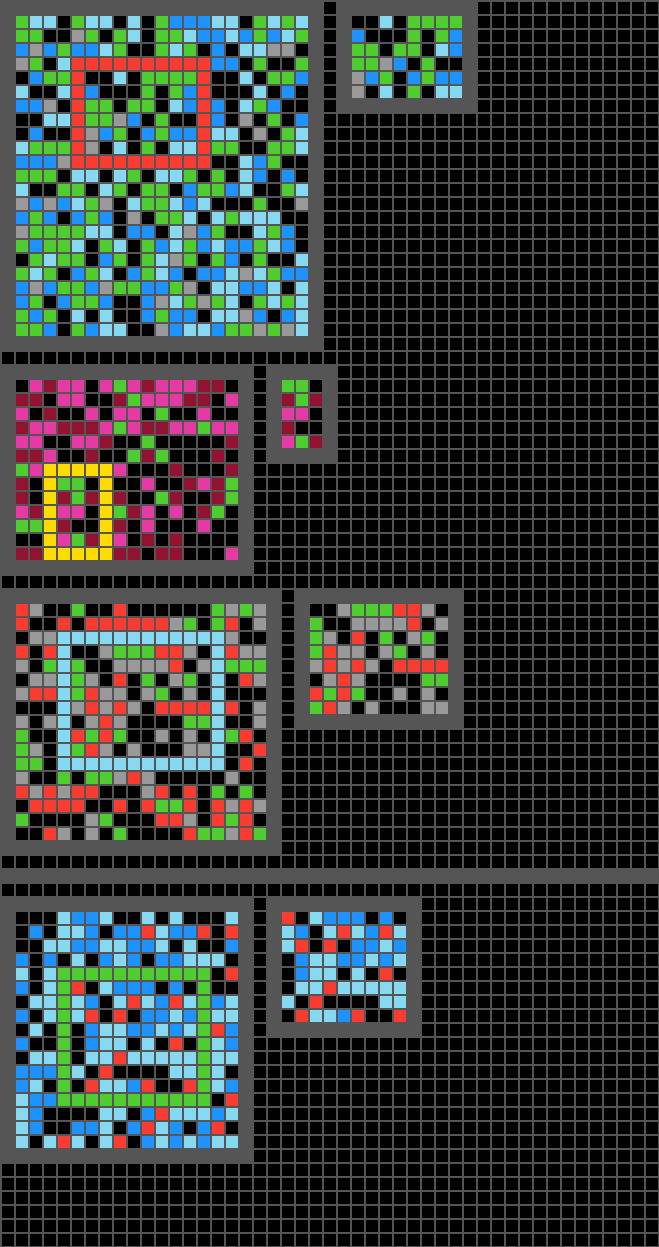

In [2]:
train_grids, test_grid = quick_load('1c786137', 'training')
visualize_problem('1c786137')

In [3]:
def get_loops(image):
    """
    Detect loops for each color in an integer array using flood fill with 8-connectivity.
    
    Args:
        image: 2D numpy array where integers represent different colors
        
    Returns:
        A list of Arc Objects, each representing a loop of a specific color
    """
    # Create a copy of the image to avoid modifying the original
    visited = np.zeros_like(image)
    # Dictionary to store loops for each color
    loops = []
    h,w = image.shape
                
    for i in range(h):
        for j in range(w):
            if visited[i, j] != 1:  # Unvisited pixel
                color = image[i, j]
                loop_mask = np.zeros_like(image)
                loop_coords = cbfs(image, j, i, color)
                for x, y in loop_coords:
                    loop_mask[y, x] = 1
                    visited[y, x] = 1
                    
                #find internal point
                ipx, ipy = -1,-1
                for x, y in loop_coords:
                    # Check all adjacent points
                    for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                        ipx, ipy = x + dx, y + dy
                        if (0 <= ipx < w and 
                            0 <= ipy < h and 
                            loop_mask[ipy, ipx] == 0):
                            # Count walls in each direction from this point
                            wall_counts = [0, 0, 0, 0]
                            
                            # Count walls to the right
                            wall_counts[0] = np.sum(loop_mask[ipy, ipx:])
                            # Count walls to the left
                            wall_counts[2] = np.sum(loop_mask[ipy, :ipx])
                            # Count walls down
                            wall_counts[1] = np.sum(loop_mask[ipy:, ipx])
                            # Count walls up
                            wall_counts[3] = np.sum(loop_mask[:ipy, ipx])
                            
                            # If we have walls in all directions, this is an internal point
                            if min(wall_counts) == 1:
                                break
                            
                # no internal points so not a loop
                if ipx == -1:
                    continue
                # print("found internal point: ", ipx, ipy)
                #find bounded space
                internal_space = cbfs(loop_mask, ipx, ipy, 0)
                # space is not bounded by loop
                if len(internal_space) + len(loop_coords) ==h*w:
                    continue
                bounded_space_mask = np.zeros_like(image)
                for x, y in internal_space:
                    bounded_space_mask[y, x] = 1
                
                
                
                loops.append((loop_mask, bounded_space_mask))
    return loops

# color bfs
def cbfs(image: np.array, x: int, y: int, target_color: int):
    frontier = deque([(x, y)])
    visited = set()
    while frontier:
        x, y = frontier.popleft()
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, 1), (1, -1), (-1, -1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < image.shape[1] and 0 <= ny < image.shape[0] and image[ny, nx] == target_color and (nx, ny) not in visited:
                frontier.append((nx, ny))
                visited.add((nx, ny))
    return visited

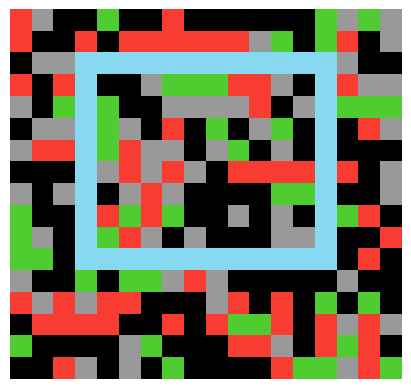

In [10]:
test_loop_image = train_grids[2]["input"]
test_loop_image.plot_grid()

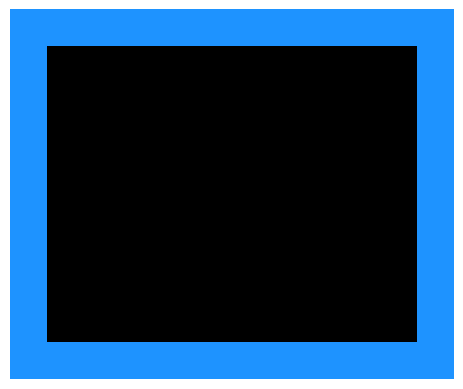

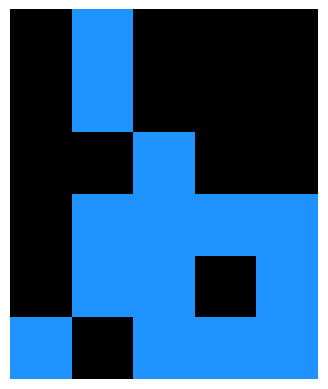

In [5]:
for loop in get_loops(test_loop_image):
    obj = ARC_Object(loop[0], mask=loop[0])
    obj.plot_grid()

In [6]:
colors = extract_objects(train_grids[2]["input"],method='color')

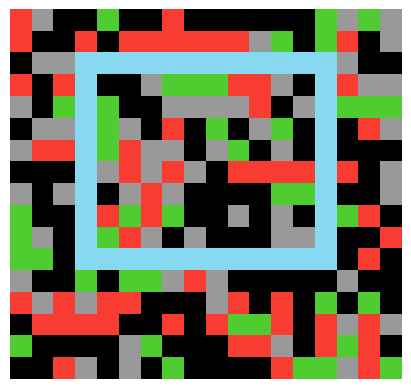

In [7]:
train_grids[2]["input"].plot_grid()

In [8]:
for color in colors:
    print(color.top_left)

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(2, 3)


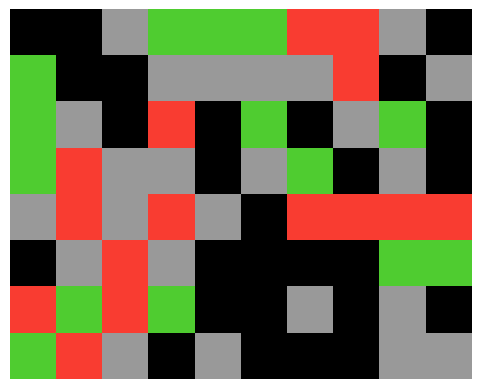

In [9]:
train_grids[2]["output"].plot_grid()